# Jakub Grzyb GGSN 2025 grupa 1

[https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

# Imports

In [305]:
import torch
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torch import tensor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Training prep

In [306]:
# for folder in ["data/NORMAL", "data/PNEUMONIA"]:
#     if os.path.exists(folder):
#         for file in os.listdir(folder):
#             file_path = os.path.join(folder, file)
#             if os.path.isfile(file_path):
#                 os.remove(file_path)

In [307]:
# from concurrent.futures import ThreadPoolExecutor

# augmentation_transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
#     transforms.ToTensor(),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
#     transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), fill=0, scale=(0.8, 1.2)),
# ])

# train_dataset = datasets.ImageFolder(root='chest_xray/train', transform=augmentation_transform)

# class_counts = np.bincount(train_dataset.targets)
# class_weights = 1.0 / class_counts
# sample_weights = class_weights[train_dataset.targets]
# sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, sampler=sampler)

# counter = 0
# def save_image(image, label, counter):
#     label_folder = "data/NORMAL" if label == 0 else "data/PNEUMONIA"
#     os.makedirs(label_folder, exist_ok=True)
#     image_path = os.path.join(label_folder, f"image_{counter}.png")
#     image = transforms.ToPILImage()(image.cpu())
#     image.save(image_path)

# with ThreadPoolExecutor() as executor:
#     futures = []
#     for i in range(9):
#         for images, labels in train_loader:
#             for img, lbl in zip(images, labels):
#                 futures.append(executor.submit(save_image, img, lbl.item(), counter))
#                 counter += 1
#             print(".", end="")
#     for future in futures:
#         future.result()  # Ensure all tasks are completed
#     print(f"\nProcessed {counter} images")

# Helpers

In [308]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [329]:
def plot_first_layer(layer, loader):
    for images, labels in loader:
        for image, label in zip(images, labels):
            image = image.unsqueeze(0).to(device)
            output = layer(image)
            output = output.squeeze().cpu().detach().numpy()
            break
        break

    fig, axes = plt.subplots(4, output.shape[0]//4, figsize=(20, 10))
    fig.suptitle("Output Channels", fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < output.shape[0]:
            ax.imshow(output[i], cmap='viridis')
            ax.axis('off')
            ax.set_title(f"Channel {i+1}")
    plt.tight_layout()
    plt.show()

In [310]:
def plot_heat_map(model, loader):
    for images, labels in loader:
        for image, label in zip(images, labels):
            image = image.unsqueeze(0).to(device)
            break
        break

    model.eval()
    image.unsqueeze(0).to(device)
    image.requires_grad = True

    output = model(image)
    target_score = output.squeeze()

    model.zero_grad()
    target_score.backward()

    saliency = image.grad.data.abs().squeeze().cpu().numpy()

    if saliency.ndim == 3:
        saliency = np.max(saliency, axis=0)

    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image.squeeze().permute(1, 2, 0).mean(dim=-1).cpu().detach().numpy(), cmap='viridis')
    ax[0].axis('off')
    ax[0].set_title(f"Original Image, label: {label}")

    ax[1].imshow(saliency, cmap='hot')
    ax[1].axis('off')
    ax[1].set_title("Saliency Map (Heatmap)")

    plt.show()

# Data

### Transform

In [311]:
data_transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [312]:
augmentation_transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), fill=0, scale=(0.8, 1.2)),
])

In [313]:
tmp_transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [314]:
train_dataset = datasets.ImageFolder(root='data', transform=tmp_transform)
# train_dataset = datasets.ImageFolder(root='chest_xray/train', transform=augmentation_transform)
val_dataset = datasets.ImageFolder(root='chest_xray/val', transform=data_transform)
test_dataset = datasets.ImageFolder(root='chest_xray/test', transform=data_transform)

In [315]:
class_counts = np.bincount(train_dataset.targets)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_dataset.targets]
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

### DataLoader

In [316]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

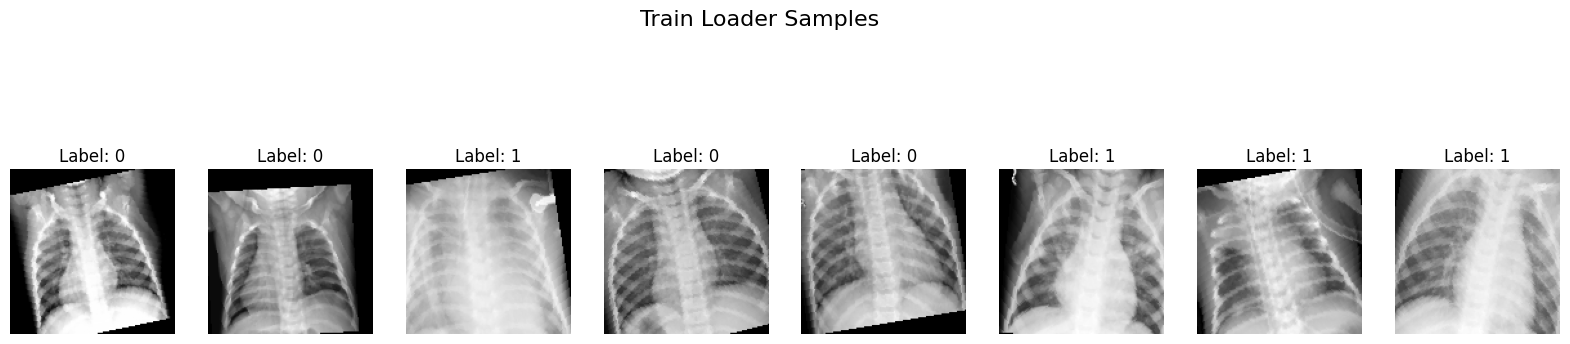

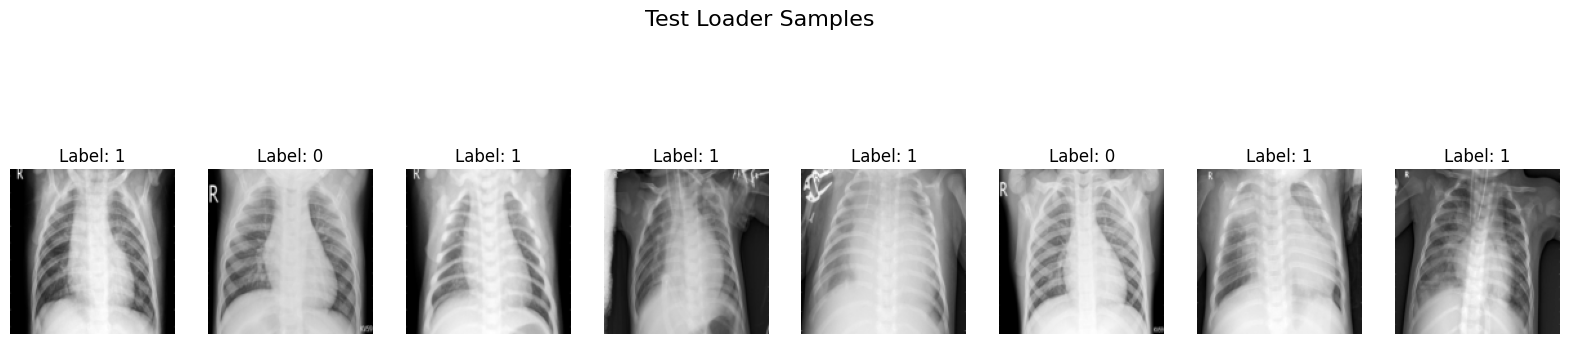

In [317]:
# Corrected show_samples function
def show_samples(loader, title):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, 8, figsize=(20, 5))
    fig.suptitle(title, fontsize=16)
    for i in range(8):
        ax = axes[i]
        # Convert from (C, H, W) to (H, W, C) for imshow
        img = images[i].permute(1, 2, 0).numpy()
        # Normalize to [0, 1] for display if necessary
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {labels[i].item()}")

# Show samples from train_loader
show_samples(train_loader, "Train Loader Samples")

# Show samples from test_loader
show_samples(test_loader, "Test Loader Samples")

# Training

In [318]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_accuracy = 0.0
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, val_accuracy, model):
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            self.best_model = model.state_dict()

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [319]:
# def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10):
    
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         running_labels = []
#         running_preds = []
#         progress = 0
#         for i, (images, labels) in enumerate(train_loader):
#             images, labels = images.to(device), labels.to(device).float()
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs.squeeze(), labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#             running_labels.extend(labels.cpu().numpy())
#             running_preds.extend((outputs.squeeze() > 0.5).cpu().numpy())

#             new_progress = i * 100 // len(train_loader)
#             if new_progress > progress:
#                 for _ in range(new_progress - progress):
#                     print("-", end='')
#                 progress = new_progress
                

#         model.eval()
#         val_loss = 0.0
#         all_labels = []
#         all_preds = []
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device).float()
#                 outputs = model(images)
#                 loss = criterion(outputs.squeeze(), labels)
#                 val_loss += loss.item()

#                 all_labels.extend(labels.cpu().numpy())
#                 all_preds.extend((outputs.squeeze() > 0.5).cpu().numpy())

#         print(f"\nEpoch [{epoch+1}/{num_epochs}], "
#               f"Train Loss: {running_loss / len(train_loader):.4f}, "
#               f"Val Loss: {val_loss / len(val_loader):.4f}, "
#               f"Train Accuracy: {accuracy_score(running_labels, running_preds) * 100:.2f}%, "
#               f"Val Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")

In [320]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=5):
    model.to(device)
    early_stopping = EarlyStopping(patience=patience)
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_labels = []
        running_preds = []
        progress = -1
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            running_labels.extend(labels.cpu().numpy())
            running_preds.extend((outputs.squeeze() > 0.5).cpu().numpy())

            new_progress = i * 10 // len(train_loader)
            if new_progress > progress:
                val_loss = 0.0
                val_labels = []
                val_preds = []
                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device).float()
                        outputs = model(images)
                        loss = criterion(outputs.squeeze(), labels)
                        val_loss += loss.item()

                        val_labels.extend(labels.cpu().numpy())
                        val_preds.extend((outputs.squeeze() > 0.5).cpu().numpy())

                train_loss = running_loss / len(train_loader)
                val_loss = val_loss / len(val_loader)
                train_accuracy = accuracy_score(running_labels, running_preds) * 100
                val_accuracy = accuracy_score(val_labels, val_preds) * 100

                history['train_loss'].append(train_loss)
                history['val_loss'].append(val_loss)
                history['train_accuracy'].append(train_accuracy)
                history['val_accuracy'].append(val_accuracy)

                print(f"\nEpoch [{epoch*10 + progress + 1}/{num_epochs*10}], "
                    f"Train Loss: {train_loss:.4f}, "
                    f"Val Loss: {val_loss:.4f}, "
                    f"Train Accuracy: {train_accuracy:.2f}%, "
                    f"Val Accuracy: {val_accuracy:.2f}%")
                
                progress = new_progress
                
                early_stopping(val_loss / len(val_loader), accuracy_score(val_labels, val_preds) * 100, model)
                if early_stopping.early_stop:
                    break

        if early_stopping.early_stop:
            model.load_state_dict(early_stopping.best_model)
            print("Early stopping")
            print(f"Best Validation Accuracy: {early_stopping.best_accuracy:.2f}%")
            print(f"Best Validation Loss: {early_stopping.best_loss:.4f}")
            break

    return model, history

# Simple Model

In [321]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.norm1 = torch.nn.BatchNorm2d(16)
        self.drop1 = torch.nn.Dropout(0.2)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.norm2 = torch.nn.BatchNorm2d(32)
        self.drop2 = torch.nn.Dropout(0.2)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = torch.nn.ReLU()
        self.norm3 = torch.nn.BatchNorm2d(64)
        self.drop3 = torch.nn.Dropout(0.2)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.flat = torch.nn.Flatten()
        self.dense = torch.nn.Linear(64 * 16 * 16, 128)
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(0.3)
        self.out = torch.nn.Linear(128, 1)
        self.output = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.pool1(self.drop1(self.norm1(self.relu1(self.conv1(x)))))
        x = self.pool2(self.drop2(self.norm2(self.relu2(self.conv2(x)))))
        x = self.pool3(self.drop3(self.norm3(self.relu3(self.conv3(x)))))
        x = self.flat(x)
        x = self.drop(self.relu(self.dense(x)))
        x = self.out(x)
        x = self.output(x)
        return x

In [322]:
model = SimpleCNN().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [323]:
model, history = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=7)


Epoch [0/100], Train Loss: 0.0005, Val Loss: 1.6665, Train Accuracy: 40.62%, Val Accuracy: 56.25%

Epoch [1/100], Train Loss: 0.0458, Val Loss: 0.6999, Train Accuracy: 83.29%, Val Accuracy: 75.00%

Epoch [2/100], Train Loss: 0.0733, Val Loss: 0.9678, Train Accuracy: 86.38%, Val Accuracy: 56.25%

Epoch [3/100], Train Loss: 0.0993, Val Loss: 0.8854, Train Accuracy: 87.50%, Val Accuracy: 68.75%

Epoch [4/100], Train Loss: 0.1193, Val Loss: 0.8661, Train Accuracy: 88.72%, Val Accuracy: 62.50%

Epoch [5/100], Train Loss: 0.1409, Val Loss: 1.3517, Train Accuracy: 89.36%, Val Accuracy: 56.25%

Epoch [6/100], Train Loss: 0.1618, Val Loss: 0.7047, Train Accuracy: 89.77%, Val Accuracy: 62.50%

Epoch [7/100], Train Loss: 0.1814, Val Loss: 0.8824, Train Accuracy: 90.16%, Val Accuracy: 75.00%

Epoch [8/100], Train Loss: 0.1989, Val Loss: 0.9058, Train Accuracy: 90.59%, Val Accuracy: 68.75%
Early stopping
Best Validation Accuracy: 75.00%
Best Validation Loss: 0.6999


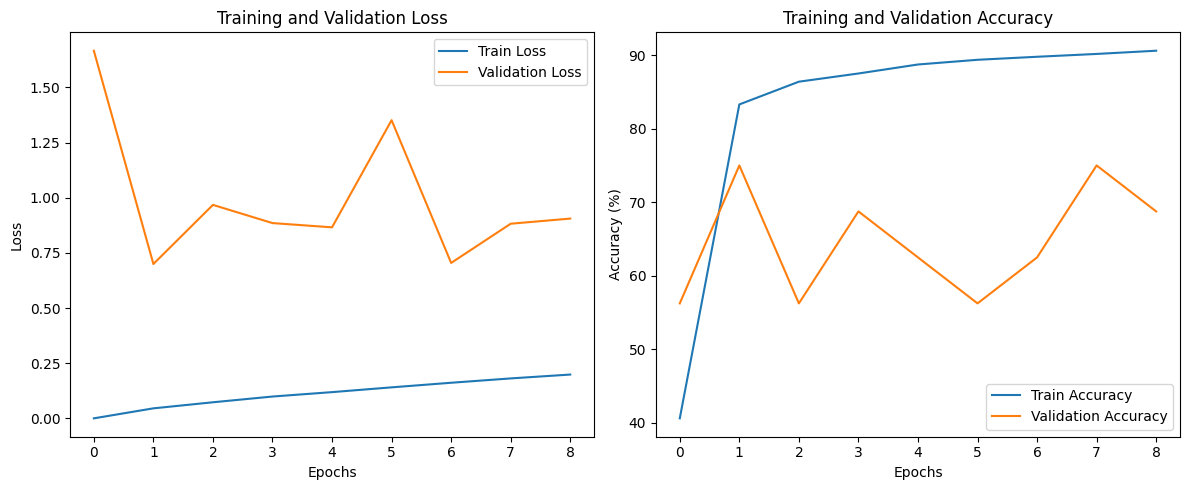

In [324]:
plot_history(history)

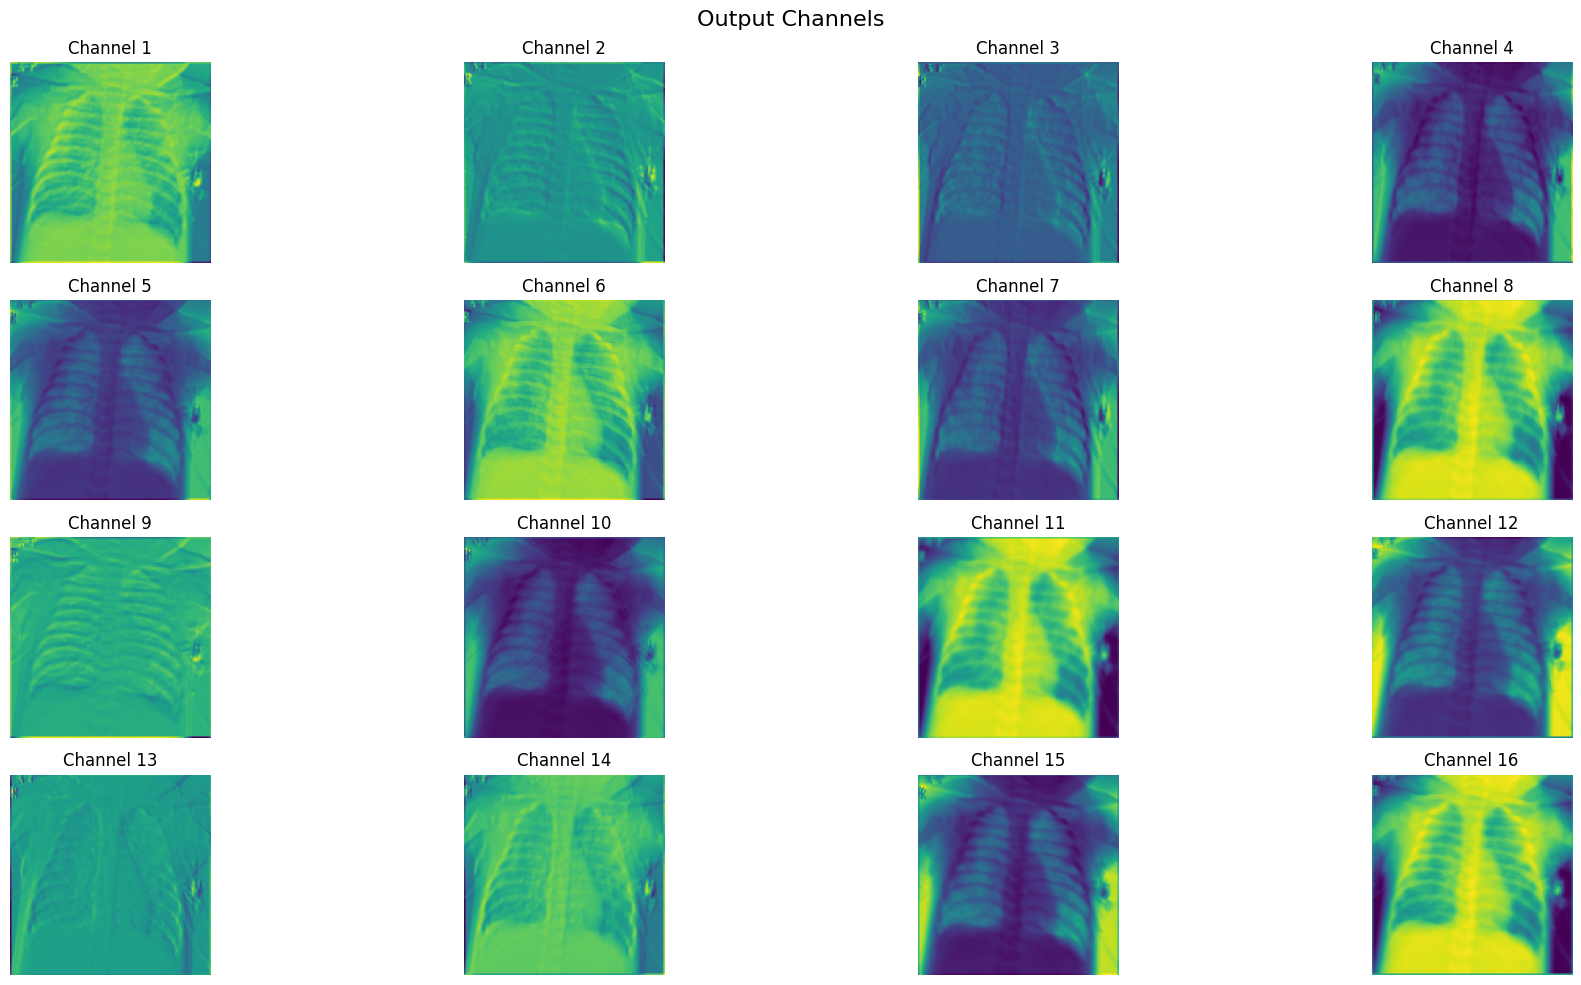

In [330]:
plot_first_layer(model.conv1, val_loader)

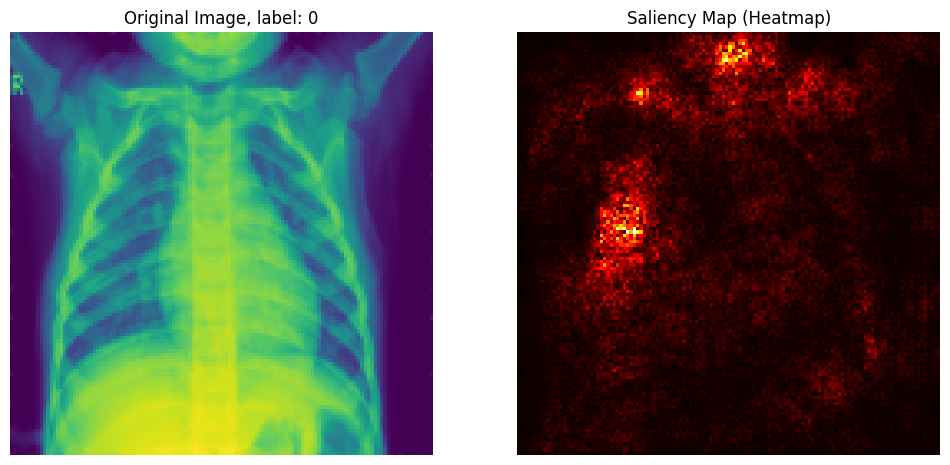

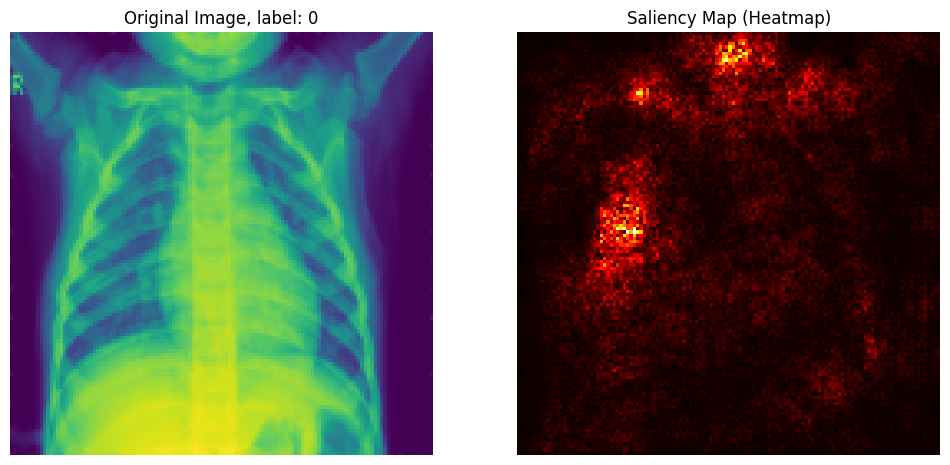

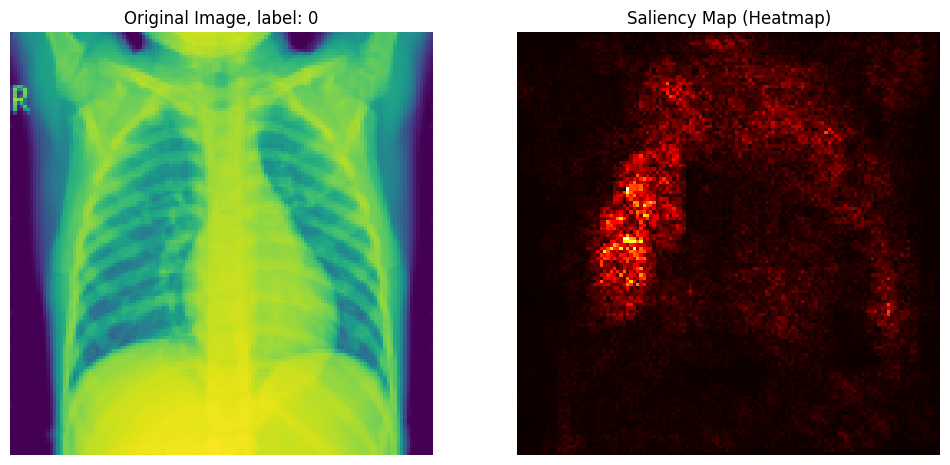

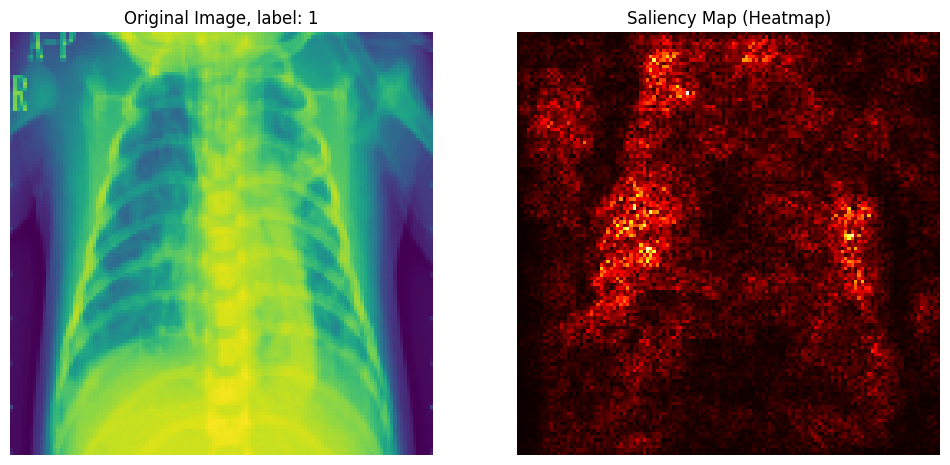

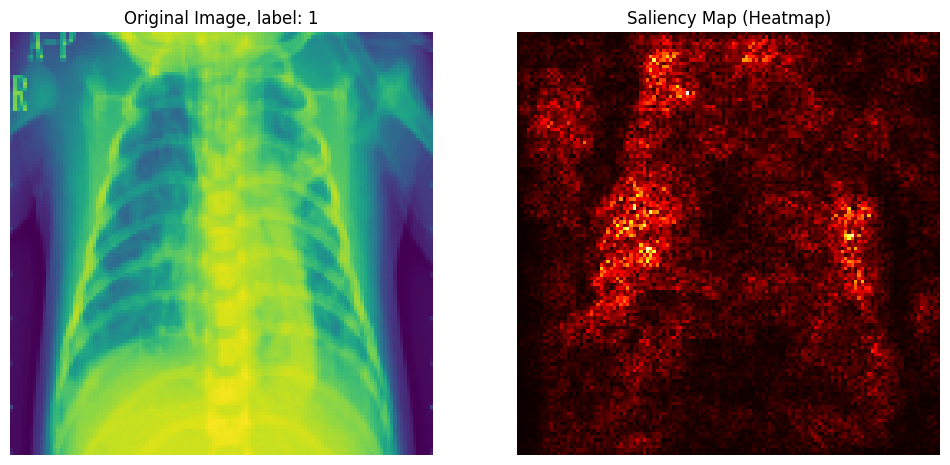

In [331]:
for _ in range(5):
    plot_heat_map(model, val_loader)

# Transfer learning

In [332]:
def create_transfer_learning_model(num_classes=1):
    model = models.mobilenet_v2(pretrained=True)

    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Linear(model.last_channel, 128),  
        nn.ReLU(),                           
        nn.Dropout(0.3),                     
        nn.Linear(128, num_classes)          
    )

    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_transfer_learning_model(num_classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [333]:
train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)


Epoch [0/100], Train Loss: 0.0004, Val Loss: 0.6561, Train Accuracy: 62.50%, Val Accuracy: 50.00%

Epoch [1/100], Train Loss: 0.0450, Val Loss: 0.4506, Train Accuracy: 76.84%, Val Accuracy: 75.00%

Epoch [2/100], Train Loss: 0.0774, Val Loss: 0.4331, Train Accuracy: 81.78%, Val Accuracy: 81.25%

Epoch [3/100], Train Loss: 0.1078, Val Loss: 0.4006, Train Accuracy: 83.72%, Val Accuracy: 87.50%

Epoch [4/100], Train Loss: 0.1362, Val Loss: 0.3689, Train Accuracy: 84.91%, Val Accuracy: 87.50%

Epoch [5/100], Train Loss: 0.1636, Val Loss: 0.3770, Train Accuracy: 85.68%, Val Accuracy: 93.75%

Epoch [6/100], Train Loss: 0.1918, Val Loss: 0.3937, Train Accuracy: 86.07%, Val Accuracy: 93.75%

Epoch [7/100], Train Loss: 0.2204, Val Loss: 0.4021, Train Accuracy: 86.32%, Val Accuracy: 87.50%

Epoch [8/100], Train Loss: 0.2487, Val Loss: 0.3653, Train Accuracy: 86.53%, Val Accuracy: 93.75%

Epoch [9/100], Train Loss: 0.2747, Val Loss: 0.3582, Train Accuracy: 86.86%, Val Accuracy: 87.50%

Epoch [10

(MobileNetV2(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU6(inplace=True)
     )
     (1): InvertedResidual(
       (conv): Sequential(
         (0): Conv2dNormActivation(
           (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
           (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): ReLU6(inplace=True)
         )
         (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       )
     )
     (2): InvertedResidual(
       (conv): Sequential(
         (0): Conv2dNormActivation(
           (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (1

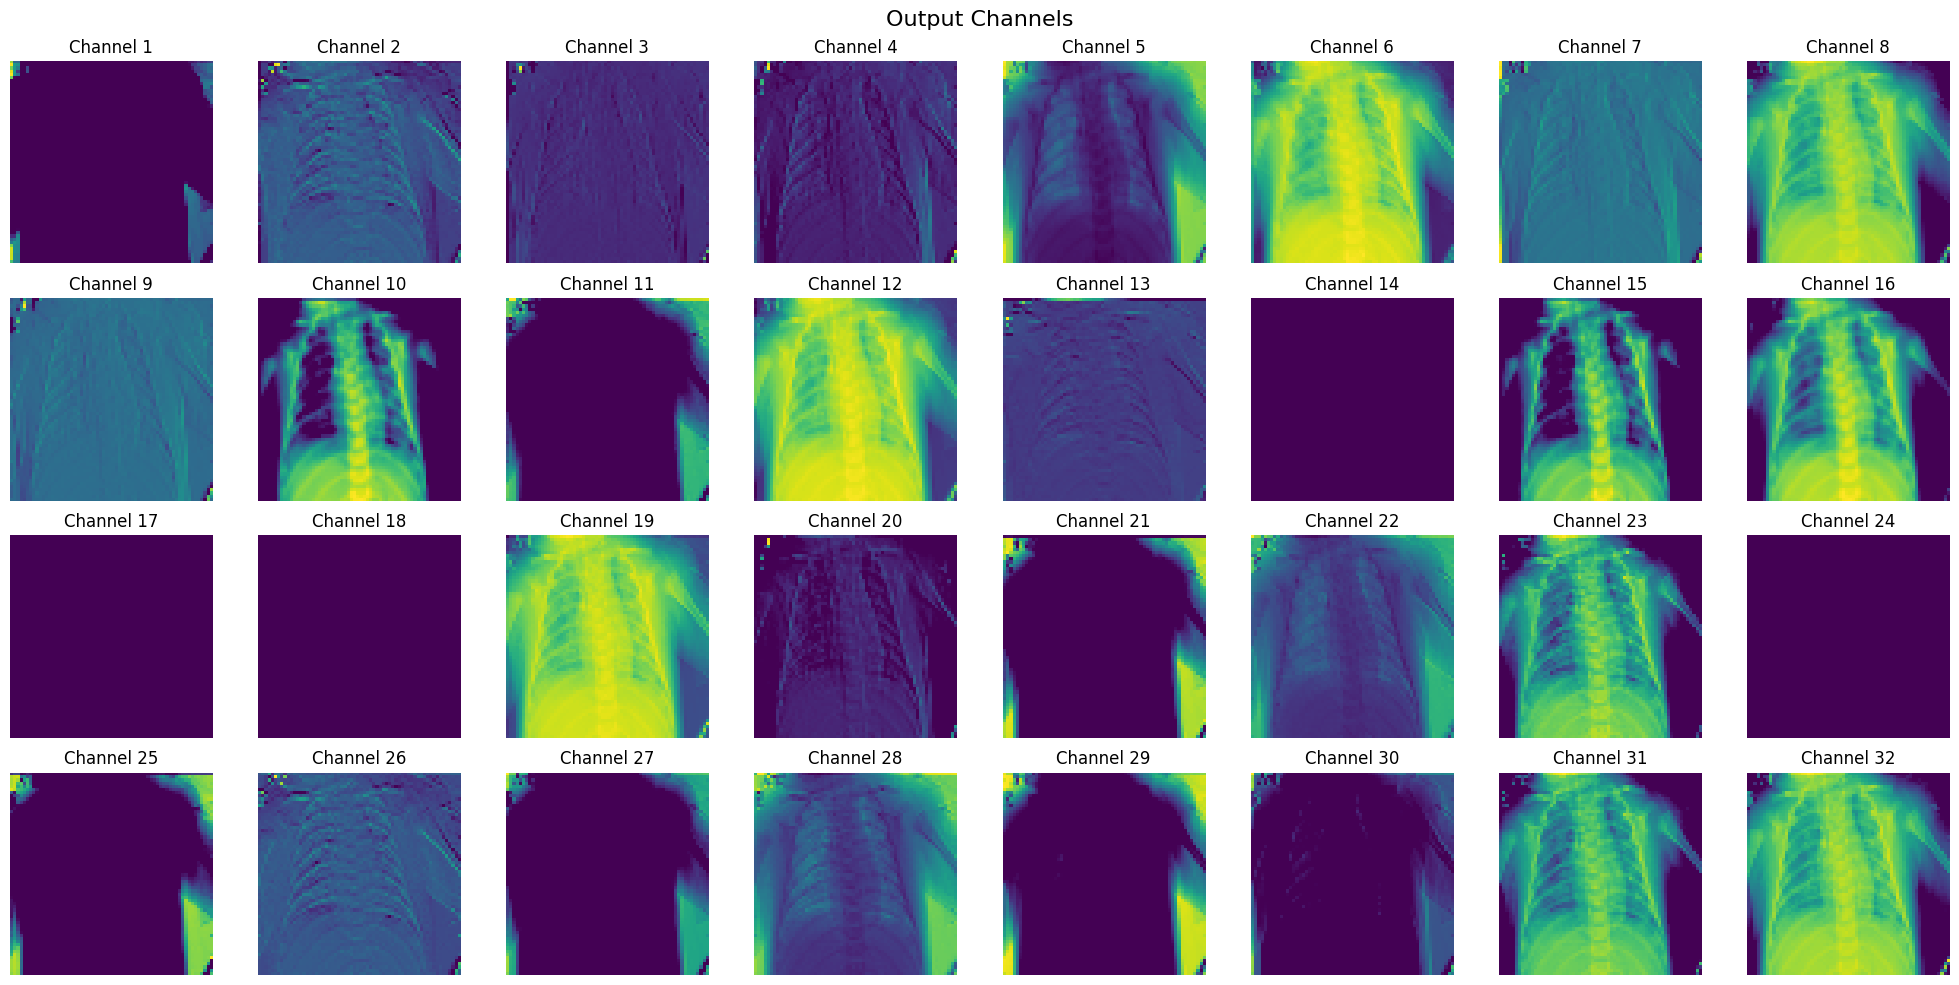

In [334]:
plot_first_layer(model.features[0], val_loader)

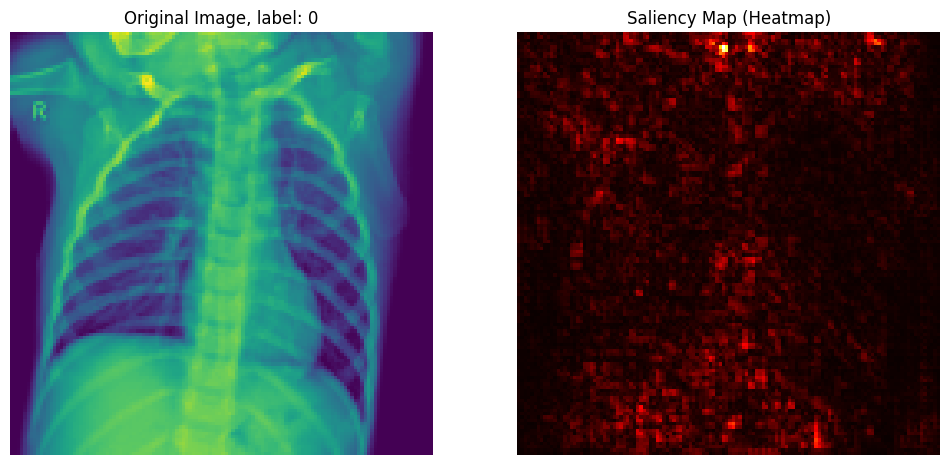

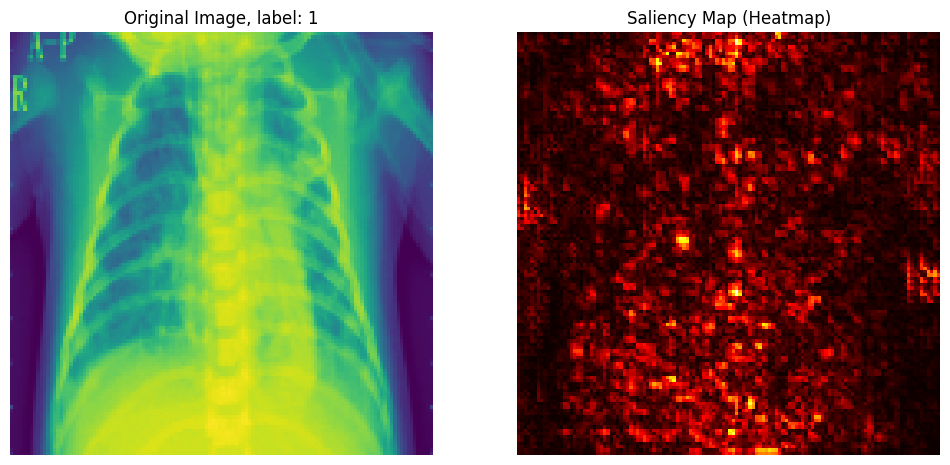

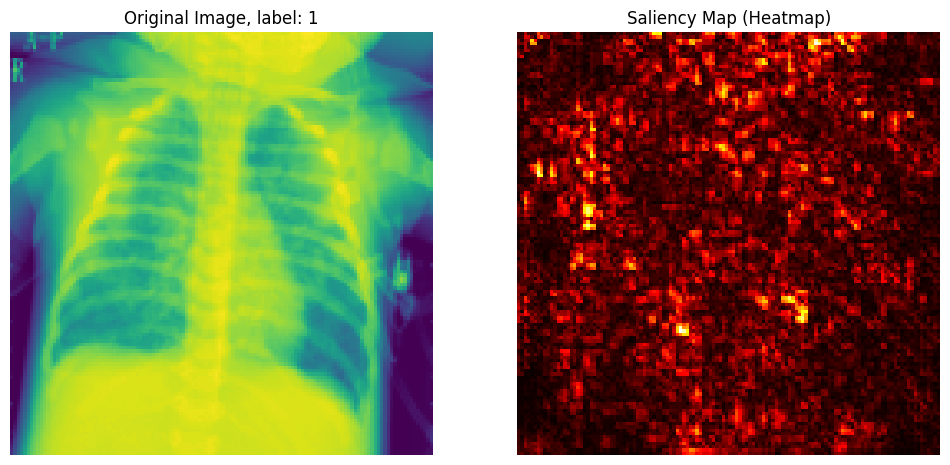

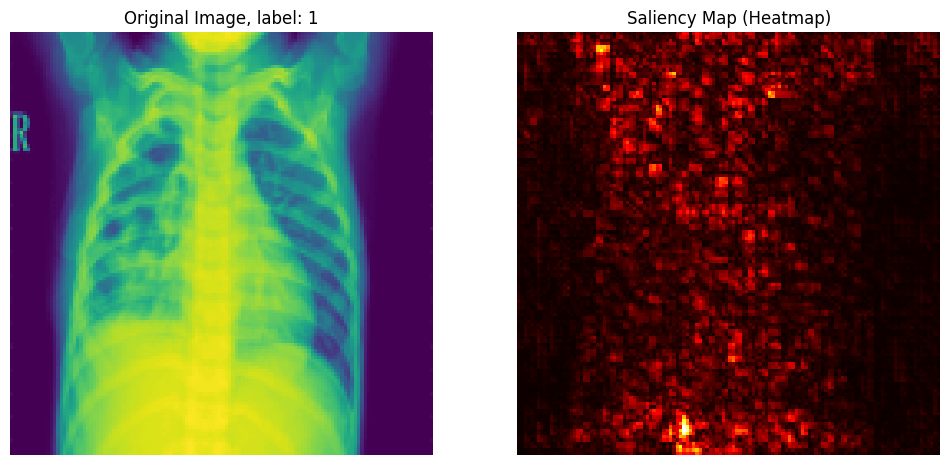

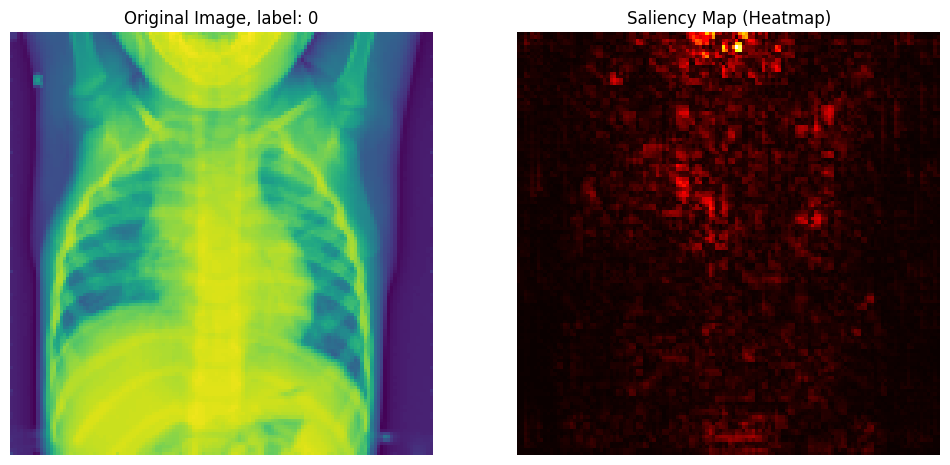

In [337]:
for _ in range(5):
    plot_heat_map(model, val_loader)